# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm
tqdm.pandas()

from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, KFold, StratifiedGroupKFold, GroupKFold
from sklearn.model_selection import TimeSeriesSplit

from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier

In [3]:
#Reduce Memory Usage
def reduce_memory_usage(df):
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            # else:
            #     df[col] = df[col].astype('category')
    
    return df

In [4]:
ignore_constant_columns =  ['Properties', 'Format', 'Time', 'Discrete', 'Realtime', 'Turns', 'Alternating', 'Simultaneous', 'HiddenInformation', 'Match', 'AsymmetricRules', 'AsymmetricPlayRules', 'AsymmetricEndRules', 'AsymmetricSetup', 'Players', 'NumPlayers', 'Simulation', 'Solitaire', 'TwoPlayer', 'Multiplayer', 'Coalition', 'Puzzle', 'DeductionPuzzle', 'PlanningPuzzle', 'Equipment', 'Container', 'Board', 'PrismShape', 'ParallelogramShape', 'RectanglePyramidalShape', 'TargetShape', 'BrickTiling', 'CelticTiling', 'QuadHexTiling', 'Hints', 'PlayableSites', 'Component', 'DiceD3', 'BiasedDice', 'Card', 'Domino', 'Rules', 'SituationalTurnKo', 'SituationalSuperko', 'InitialAmount', 'InitialPot', 'Play', 'BetDecision', 'BetDecisionFrequency', 'VoteDecisionFrequency', 'ChooseTrumpSuitDecision', 'ChooseTrumpSuitDecisionFrequency', 'LeapDecisionToFriend', 'LeapDecisionToFriendFrequency', 'HopDecisionEnemyToFriend', 'HopDecisionEnemyToFriendFrequency', 'HopDecisionFriendToFriend', 'FromToDecisionWithinBoard', 'FromToDecisionBetweenContainers', 'BetEffect', 'BetEffectFrequency', 'VoteEffectFrequency', 'SwapPlayersEffectFrequency', 'TakeControl', 'TakeControlFrequency', 'PassEffectFrequency', 'SetCost', 'SetCostFrequency', 'SetPhase', 'SetPhaseFrequency', 'SetTrumpSuit', 'SetTrumpSuitFrequency', 'StepEffectFrequency', 'SlideEffectFrequency', 'LeapEffectFrequency', 'HopEffectFrequency', 'FromToEffectFrequency', 'SwapPiecesEffect', 'SwapPiecesEffectFrequency', 'ShootEffect', 'ShootEffectFrequency', 'MaxCapture', 'OffDiagonalDirection', 'Information', 'HidePieceType', 'HidePieceOwner', 'HidePieceCount', 'HidePieceRotation', 'HidePieceValue', 'HidePieceState', 'InvisiblePiece', 'End', 'LineDrawFrequency', 'ConnectionDraw', 'ConnectionDrawFrequency', 'GroupLossFrequency', 'GroupDrawFrequency', 'LoopLossFrequency', 'LoopDraw', 'LoopDrawFrequency', 'PatternLoss', 'PatternLossFrequency', 'PatternDraw', 'PatternDrawFrequency', 'PathExtentEndFrequency', 'PathExtentWinFrequency', 'PathExtentLossFrequency', 'PathExtentDraw', 'PathExtentDrawFrequency', 'TerritoryLoss', 'TerritoryLossFrequency', 'TerritoryDraw', 'TerritoryDrawFrequency', 'CheckmateLoss', 'CheckmateLossFrequency', 'CheckmateDraw', 'CheckmateDrawFrequency', 'NoTargetPieceLoss', 'NoTargetPieceLossFrequency', 'NoTargetPieceDraw', 'NoTargetPieceDrawFrequency', 'NoOwnPiecesDraw', 'NoOwnPiecesDrawFrequency', 'FillLoss', 'FillLossFrequency', 'FillDraw', 'FillDrawFrequency', 'ScoringDrawFrequency', 'NoProgressWin', 'NoProgressWinFrequency', 'NoProgressLoss', 'NoProgressLossFrequency', 'SolvedEnd', 'PositionalRepetition', 'SituationalRepetition', 'Narrowness', 'Variance', 'DecisivenessMoves', 'DecisivenessThreshold', 'LeadChange', 'Stability', 'DramaAverage', 'DramaMedian', 'DramaMaximum', 'DramaMinimum', 'DramaVariance', 'DramaChangeAverage', 'DramaChangeSign', 'DramaChangeLineBestFit', 'DramaChangeNumTimes', 'DramaMaxIncrease', 'DramaMaxDecrease', 'MoveEvaluationAverage', 'MoveEvaluationMedian', 'MoveEvaluationMaximum', 'MoveEvaluationMinimum', 'MoveEvaluationVariance', 'MoveEvaluationChangeAverage', 'MoveEvaluationChangeSign', 'MoveEvaluationChangeLineBestFit', 'MoveEvaluationChangeNumTimes', 'MoveEvaluationMaxIncrease', 'MoveEvaluationMaxDecrease', 'StateEvaluationDifferenceAverage', 'StateEvaluationDifferenceMedian', 'StateEvaluationDifferenceMaximum', 'StateEvaluationDifferenceMinimum', 'StateEvaluationDifferenceVariance', 'StateEvaluationDifferenceChangeAverage', 'StateEvaluationDifferenceChangeSign', 'StateEvaluationDifferenceChangeLineBestFit', 'StateEvaluationDifferenceChangeNumTimes', 'StateEvaluationDifferenceMaxIncrease', 'StateEvaluationDifferenceMaxDecrease', 'BoardSitesOccupiedMinimum', 'BranchingFactorMinimum', 'DecisionFactorMinimum', 'MoveDistanceMinimum', 'PieceNumberMinimum', 'ScoreDifferenceMinimum', 'ScoreDifferenceChangeNumTimes', 'Roots', 'Cosine', 'Sine', 'Tangent', 'Exponential', 'Logarithm', 'ExclusiveDisjunction', 'Float', 'HandComponent', 'SetHidden', 'SetInvisible', 'SetHiddenCount', 'SetHiddenRotation', 'SetHiddenState', 'SetHiddenValue', 'SetHiddenWhat', 'SetHiddenWho']
ignore_null_columns = ['Behaviour', 'StateRepetition', 'Duration', 'Complexity', 'BoardCoverage', 'GameOutcome', 'StateEvaluation', 'Clarity', 'Decisiveness', 'Drama', 'MoveEvaluation', 'StateEvaluationDifference', 'BoardSitesOccupied', 'BranchingFactor', 'DecisionFactor', 'MoveDistance', 'PieceNumber', 'ScoreDifference']
ignore_game_columns = ['GameRulesetName', 'EnglishRules', 'LudRules']
new_duplicates = ['AsymmetricForces','AsymmetricPiecesType','PieceDirection','Team','SpiralTiling','CircleTiling','ShibumiStyle','Sow','MancalaStyle','NumPerimeterSites','SetRotation','Roll','SwapOption','SetRotationFrequency','PathExtent','LoopLoss','PathExtentEnd','PathExtentWin','PathExtentLoss','SowOriginFirst','LoopEnd','TerritoryEnd','TerritoryWin','LeftwardDirection','LeftwardsDirection','ForwardRightDirection','BackwardRightDirection','LoopWinFrequency','PatternWin','PatternWinFrequency','TerritoryWinFrequency','NoProgressDrawFrequency','StackState']

# Read the training and testing data


In [5]:
train_df = pd.read_csv("um-game-playing-strength-of-mcts-variants/train.csv")
test_df = pd.read_csv("um-game-playing-strength-of-mcts-variants/test.csv")

### Drop id
train_df = train_df.drop('Id',axis=1).drop_duplicates().reset_index(drop=True)

#### Get the groups
groups = train_df['GameRulesetName'].copy()

#### Drop columns
train_df = train_df.drop(ignore_null_columns + ignore_constant_columns + ignore_game_columns + new_duplicates,axis=1)
test_df = test_df.drop(ignore_null_columns + ignore_constant_columns + ignore_game_columns + new_duplicates,axis=1)
train_df.shape

(233234, 561)

In [6]:
test_df.drop('Id',inplace=True,axis=1)

In [7]:
# Add eight features extracted from player names
def extract_agent_info(df, agent_col, prefix):
    df[f'{prefix}_selection'] = df[agent_col].str.extract(r'MCTS-(.*)-(.*)-(.*)-(.*)', expand=True)[0]
    df[f'{prefix}_exploration'] = df[agent_col].str.extract(r'MCTS-(.*)-(.*)-(.*)-(.*)', expand=True)[1].astype(float)
    df[f'{prefix}_playout'] = df[agent_col].str.extract(r'MCTS-(.*)-(.*)-(.*)-(.*)', expand=True)[2]
    df[f'{prefix}_bounds'] = df[agent_col].str.extract(r'MCTS-(.*)-(.*)-(.*)-(.*)', expand=True)[3]

extract_agent_info(train_df, 'agent1', 'p1')
extract_agent_info(train_df, 'agent2', 'p2')
extract_agent_info(test_df, 'agent1', 'p1')
extract_agent_info(test_df, 'agent2', 'p2')

In [8]:
train_df = reduce_memory_usage(train_df)
test_df = reduce_memory_usage(test_df)

# Encoding

In [9]:
feats = list(train_df.select_dtypes(include=['object','category']).columns)
le = LabelEncoder()
df = train_df
for f in feats:
    le.fit(df[f])
    train_df[f] = le.transform(train_df[f])

# Modeling

## Validation:

In [10]:
cb_params = {'depth': 9, 'task_type':'GPU','verbose':0, 'thread_count':64, 'iterations':20000, 'bagging_temperature':0.5}
cb = CatBoostRegressor(**cb_params, random_state=42)
cb1 = CatBoostRegressor(**cb_params, random_state=42)

In [ ]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize predictions for both models and their TTAs
model1_orig = np.zeros((len(train_df),))
model1_tta = np.zeros((len(train_df),))
model2_orig = np.zeros((len(train_df),))
model2_tta = np.zeros((len(train_df),))

print('Validating...')
X = train_df.drop(['utility_agent1', 'num_wins_agent1', 'num_draws_agent1', 'num_losses_agent1',], axis=1)
y = train_df['utility_agent1'].values  
scores = []

# Cross-validation loop
kf = GroupKFold(n_splits=8)
for fold, (train_index, test_index) in enumerate(kf.split(X, y.astype(str), groups=groups)):
    X_Train, X_Test = X.loc[train_index,:], X.loc[test_index,:]
    y_Train, y_Test = y[train_index].copy(), y[test_index].copy()
    
    # Train first model
    cb.fit(X_Train, y_Train - X_Train["AdvantageP1"])
    
    # Original predictions for model 1
    model1_orig[test_index] = cb.predict(X_Test) + X_Test["AdvantageP1"]
    
    # TTA predictions for model 1
    X_Test_tta = X_Test.copy()
    X_Test_tta['AdvantageP1'] = 1 - X_Test_tta['AdvantageP1']
    X_Test_tta['agent1'], X_Test_tta['agent2'] = X_Test_tta['agent2'], X_Test_tta['agent1']
    X_Test_tta["p1_selection"], X_Test_tta["p2_selection"] = X_Test_tta["p2_selection"], X_Test_tta["p1_selection"] 
    X_Test_tta["p1_exploration"], X_Test_tta["p2_exploration"] = X_Test_tta["p2_exploration"], X_Test_tta["p1_exploration"] 
    X_Test_tta["p1_playout"], X_Test_tta["p2_playout"] = X_Test_tta["p2_playout"], X_Test_tta["p1_playout"] 
    X_Test_tta["p1_bounds"], X_Test_tta["p2_bounds"] = X_Test_tta["p2_bounds"], X_Test_tta["p1_bounds"] 
    model1_tta[test_index] = -(cb.predict(X_Test_tta) + X_Test_tta["AdvantageP1"])
    
    # # Train second model
    X_Train_flipped = X_Train.copy()
    X_Train_flipped['AdvantageP1'] = 1 - X_Train_flipped['AdvantageP1']
    X_Train_flipped['agent1'], X_Train_flipped['agent2'] = X_Train_flipped['agent2'], X_Train_flipped['agent1']
    X_Train_flipped["p1_selection"], X_Train_flipped["p2_selection"] = X_Train_flipped["p2_selection"], X_Train_flipped["p1_selection"] 
    X_Train_flipped["p1_exploration"], X_Train_flipped["p2_exploration"] = X_Train_flipped["p2_exploration"], X_Train_flipped["p1_exploration"] 
    X_Train_flipped["p1_playout"], X_Train_flipped["p2_playout"] = X_Train_flipped["p2_playout"], X_Train_flipped["p1_playout"] 
    X_Train_flipped["p1_bounds"], X_Train_flipped["p2_bounds"] = X_Train_flipped["p2_bounds"], X_Train_flipped["p1_bounds"] 
    y_Train_flipped = -y_Train
    
    cb.fit(X_Train_flipped, y_Train_flipped - X_Train_flipped["AdvantageP1"])
    
    # Original predictions for model 2
    model2_orig[test_index] = cb.predict(X_Test) + X_Test["AdvantageP1"]
    
    # TTA predictions for model 2
    model2_tta[test_index] = -(cb.predict(X_Test_tta) + X_Test_tta["AdvantageP1"])
    
    # Calculate score using original predictions for logging
    score = mean_squared_error(y_Test, model1_orig[test_index], squared=False)
    scores.append(score)
    print(f"Fold {fold} RMSE: {score}")


# Clip all predictions
model1_orig = np.clip(model1_orig, -1, 1)
model1_tta = np.clip(model1_tta, -1, 1)
model2_orig = np.clip(model2_orig, -1, 1)
model2_tta = np.clip(model2_tta, -1, 1)

# Print overall scores
print("\nMean:", np.mean(scores), "\nSTD:", np.std(scores))
print(f"Model 1 Original RMSE: {mean_squared_error(y, model1_orig, squared=False)}")
print(f"Model 1 TTA RMSE: {mean_squared_error(y, model1_tta, squared=False)}")
print(f"Model 2 Original RMSE: {mean_squared_error(y, model2_orig, squared=False)}")
print(f"Model 2 TTA RMSE: {mean_squared_error(y, model2_tta, squared=False)}")



# Fold 0 RMSE: 0.37132873192649085
# Fold 1 RMSE: 0.4129561826686694
# Fold 2 RMSE: 0.429215159764585
# Fold 3 RMSE: 0.38179947998985564
# Fold 4 RMSE: 0.3930416564862146
# Fold 5 RMSE: 0.4572805673503493
# Fold 6 RMSE: 0.4699059184622332
# Fold 7 RMSE: 0.405940171824632

# Mean: 0.4151834835591287 
# STD: 0.03275284034412601
# Model 1 Original RMSE: 0.4164742227447537
# Model 1 TTA RMSE: 0.45926010464481865
# Model 2 Original RMSE: 0.4595800340796095
# Model 2 TTA RMSE: 0.41651832635014396

In [ ]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize predictions for both models and their TTAs
model1_orig = np.zeros((len(train_df),))
model1_tta = np.zeros((len(train_df),))

print('Validating...')
X = train_df.drop(['utility_agent1', 'num_wins_agent1', 'num_draws_agent1', 'num_losses_agent1',], axis=1)
y = train_df['utility_agent1'].values  
scores = []

# Cross-validation loop
kf = GroupKFold(n_splits=8)
for fold, (train_index, test_index) in enumerate(kf.split(X, y.astype(str), groups=groups)):
    X_Train, X_Test = X.loc[train_index,:], X.loc[test_index,:]
    y_Train, y_Test = y[train_index].copy(), y[test_index].copy()
    
    # Train first model
    lgbm.fit(X_Train, y_Train)
    
    # Original predictions for model 1
    model1_orig[test_index] = lgbm.predict(X_Test) 
    
    # TTA predictions for model 1
    X_Test_tta = X_Test.copy()
    X_Test_tta['AdvantageP1'] = 1 - X_Test_tta['AdvantageP1']
    X_Test_tta['agent1'], X_Test_tta['agent2'] = X_Test_tta['agent2'], X_Test_tta['agent1']
    X_Test_tta["p1_selection"], X_Test_tta["p2_selection"] = X_Test_tta["p2_selection"], X_Test_tta["p1_selection"] 
    X_Test_tta["p1_exploration"], X_Test_tta["p2_exploration"] = X_Test_tta["p2_exploration"], X_Test_tta["p1_exploration"] 
    X_Test_tta["p1_playout"], X_Test_tta["p2_playout"] = X_Test_tta["p2_playout"], X_Test_tta["p1_playout"] 
    X_Test_tta["p1_bounds"], X_Test_tta["p2_bounds"] = X_Test_tta["p2_bounds"], X_Test_tta["p1_bounds"] 
    model1_tta[test_index] = -(lgbm.predict(X_Test_tta))

    # Calculate score using original predictions for logging
    score = mean_squared_error(y_Test, model1_orig[test_index], squared=False)
    scores.append(score)
    print(f"Fold {fold} RMSE: {score}")


# Clip all predictions
model1_orig = np.clip(model1_orig, -1, 1)
model1_tta = np.clip(model1_tta, -1, 1)


# Print overall scores
print("\nMean:", np.mean(scores), "\nSTD:", np.std(scores))
print(f"Model 1 Original RMSE: {mean_squared_error(y, model1_orig, squared=False)}")
print(f"Model 1 TTA RMSE: {mean_squared_error(y, model1_tta, squared=False)}")

In [ ]:
import joblib
y = train_df['utility_agent1'].values 

dart = joblib.load("lgb_oof_preds").reshape(-1,)
dart_tta = -joblib.load("lgb_oof_preds2").reshape(-1,)
sub1_tta = pd.read_csv("model1_tta_dart_new.csv").values.reshape(-1,)
sub2 = pd.read_csv("model1_orig.csv").values.reshape(-1,)
advp1_utility = -(train_df["AdvantageP1"] - (1 - train_df["AdvantageP1"])).values.reshape(-1,)

subs = [np.clip(dart,-1,1),
        np.clip(dart_tta,-1,1),
        np.clip(sub1_tta,-1,1),
       np.clip(sub2,-1,1), 
        advp1_utility,
       ]

In [36]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

def KLD(params, subs, y_true):
    """
    Optimization function that handles weights, scales, constants, and final clip range
    params structure: [weights..., scales..., constants..., clip_lower, clip_upper]
    """
    n_models = len(subs)
    
    # Split params into weights, scales, and constants
    weights = params[:n_models]
    scales = params[n_models:2*n_models]
    constants = params[2*n_models:3*n_models]
    clip_lower, clip_upper = params[3*n_models], params[3*n_models+1]
    
    # Apply transformations and compute weighted sum
    transformed_subs = [(scale * sub + const) for scale, sub, const 
                       in zip(scales, subs, constants)]
    ensemble_prediction = sum(w * s for w, s in zip(weights, transformed_subs))
    
    return np.sqrt(mean_squared_error(y_true, np.clip(ensemble_prediction, clip_lower, clip_upper)))

def optimize_ensemble(subs, y):
    n_models = len(subs)
    
    # Initial values
    initial_weights = [1/n_models] * n_models  # Equal weights
    initial_scales = [1.0] * n_models          # No scaling
    initial_constants = [0.0] * n_models       # No shift
    initial_clip_lower = -1.0  # Starting lower clip value
    initial_clip_upper = 1.0   # Starting upper clip value
    initial_params = (
        initial_weights + 
        initial_scales + 
        initial_constants + 
        [initial_clip_lower, initial_clip_upper]
    )
    
    # Constraints
    constraints = [
        # Weights sum to 1
        {'type': 'eq', 'fun': lambda p: sum(p[:n_models]) - 1},
        # Ensure lower clip is less than upper clip
        {'type': 'ineq', 'fun': lambda p: p[-1] - p[-2]}
    ]
    
    # Bounds
    weight_bounds = [(0, 1)] * n_models           # Weights between 0 and 1
    scale_bounds = [(0, 10)] * n_models           # Reasonable scale range
    constant_bounds = [(-10, 10)] * n_models      # Reasonable constant range
    clip_bounds = [(-1.5, -0.5), (0.5, 1.5)]           # Lower and upper clip ranges
    bounds = (
        weight_bounds + 
        scale_bounds + 
        constant_bounds + 
        clip_bounds
    )
    
    # Perform optimization
    opt_result = minimize(
        KLD, 
        initial_params, 
        args=(subs, y),
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints
    )
    
    # Extract results
    optimal_params = opt_result.x
    optimal_weights = optimal_params[:n_models]
    optimal_scales = optimal_params[n_models:2*n_models]
    optimal_constants = optimal_params[2*n_models:3*n_models]
    optimal_clip_lower, optimal_clip_upper = optimal_params[3*n_models], optimal_params[3*n_models+1]
    optimized_cv = KLD(optimal_params, subs, y)
    
    return {
        'weights': optimal_weights,
        'scales': optimal_scales,
        'constants': optimal_constants,
        'clip_lower': optimal_clip_lower,
        'clip_upper': optimal_clip_upper,
        'cv_score': optimized_cv
    }

# Example usage
results = optimize_ensemble(subs, y)

print("Optimal weights:", results['weights'])
print("Optimal scales:", results['scales'])
print("Optimal constants:", results['constants'])
print("Optimal clip lower bound:", results['clip_lower'])
print("Optimal clip upper bound:", results['clip_upper'])
print("Optimized Ensemble CV:", results['cv_score'])

Optimal weights: [0.4077008  0.05278073 0.09134096 0.40293    0.04524751]
Optimal scales: [1.22178925 1.13921763 1.12503199 1.22637187 1.        ]
Optimal constants: [0.01808395 0.01386244 0.01420963 0.01798725 0.        ]
Optimal clip lower bound: -0.9700797184315739
Optimal clip upper bound: 0.957430028027563
Optimized Ensemble CV: 0.40495530883375047


In [27]:
def apply_ensemble(submissions, weights, scales, constants):

    # Transform each submission and compute weighted sum
    transformed_subs = [(scale * sub + const) 
                       for sub, scale, const 
                       in zip(submissions, scales, constants)]
    
    # Compute weighted sum
    ensemble_prediction = sum(weight * sub 
                            for weight, sub 
                            in zip(weights, transformed_subs))
    
    return np.clip(ensemble_prediction,results['clip_lower'], results['clip_upper'])

# Example usage:

# Your optimized parameters
weights = results['weights']
scales = results['scales']
constants = results['constants']

# Apply to new submissions
predictions = apply_ensemble(subs, weights, scales, constants)
predictions

array([-0.24347281,  0.07990657,  0.2195733 , ...,  0.21937565,
        0.19245161,  0.02916523])

<Axes: >

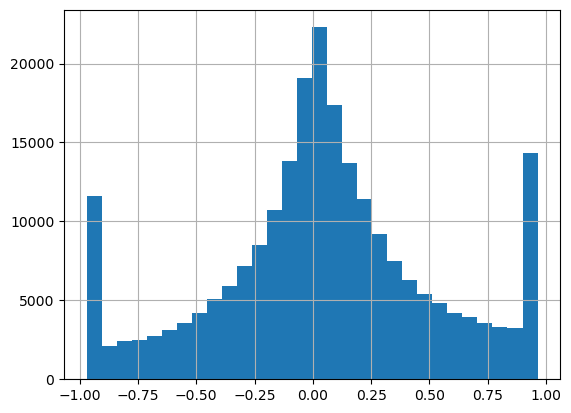

In [28]:
pd.Series(predictions).hist(bins=30)

## Show the Features Importances 

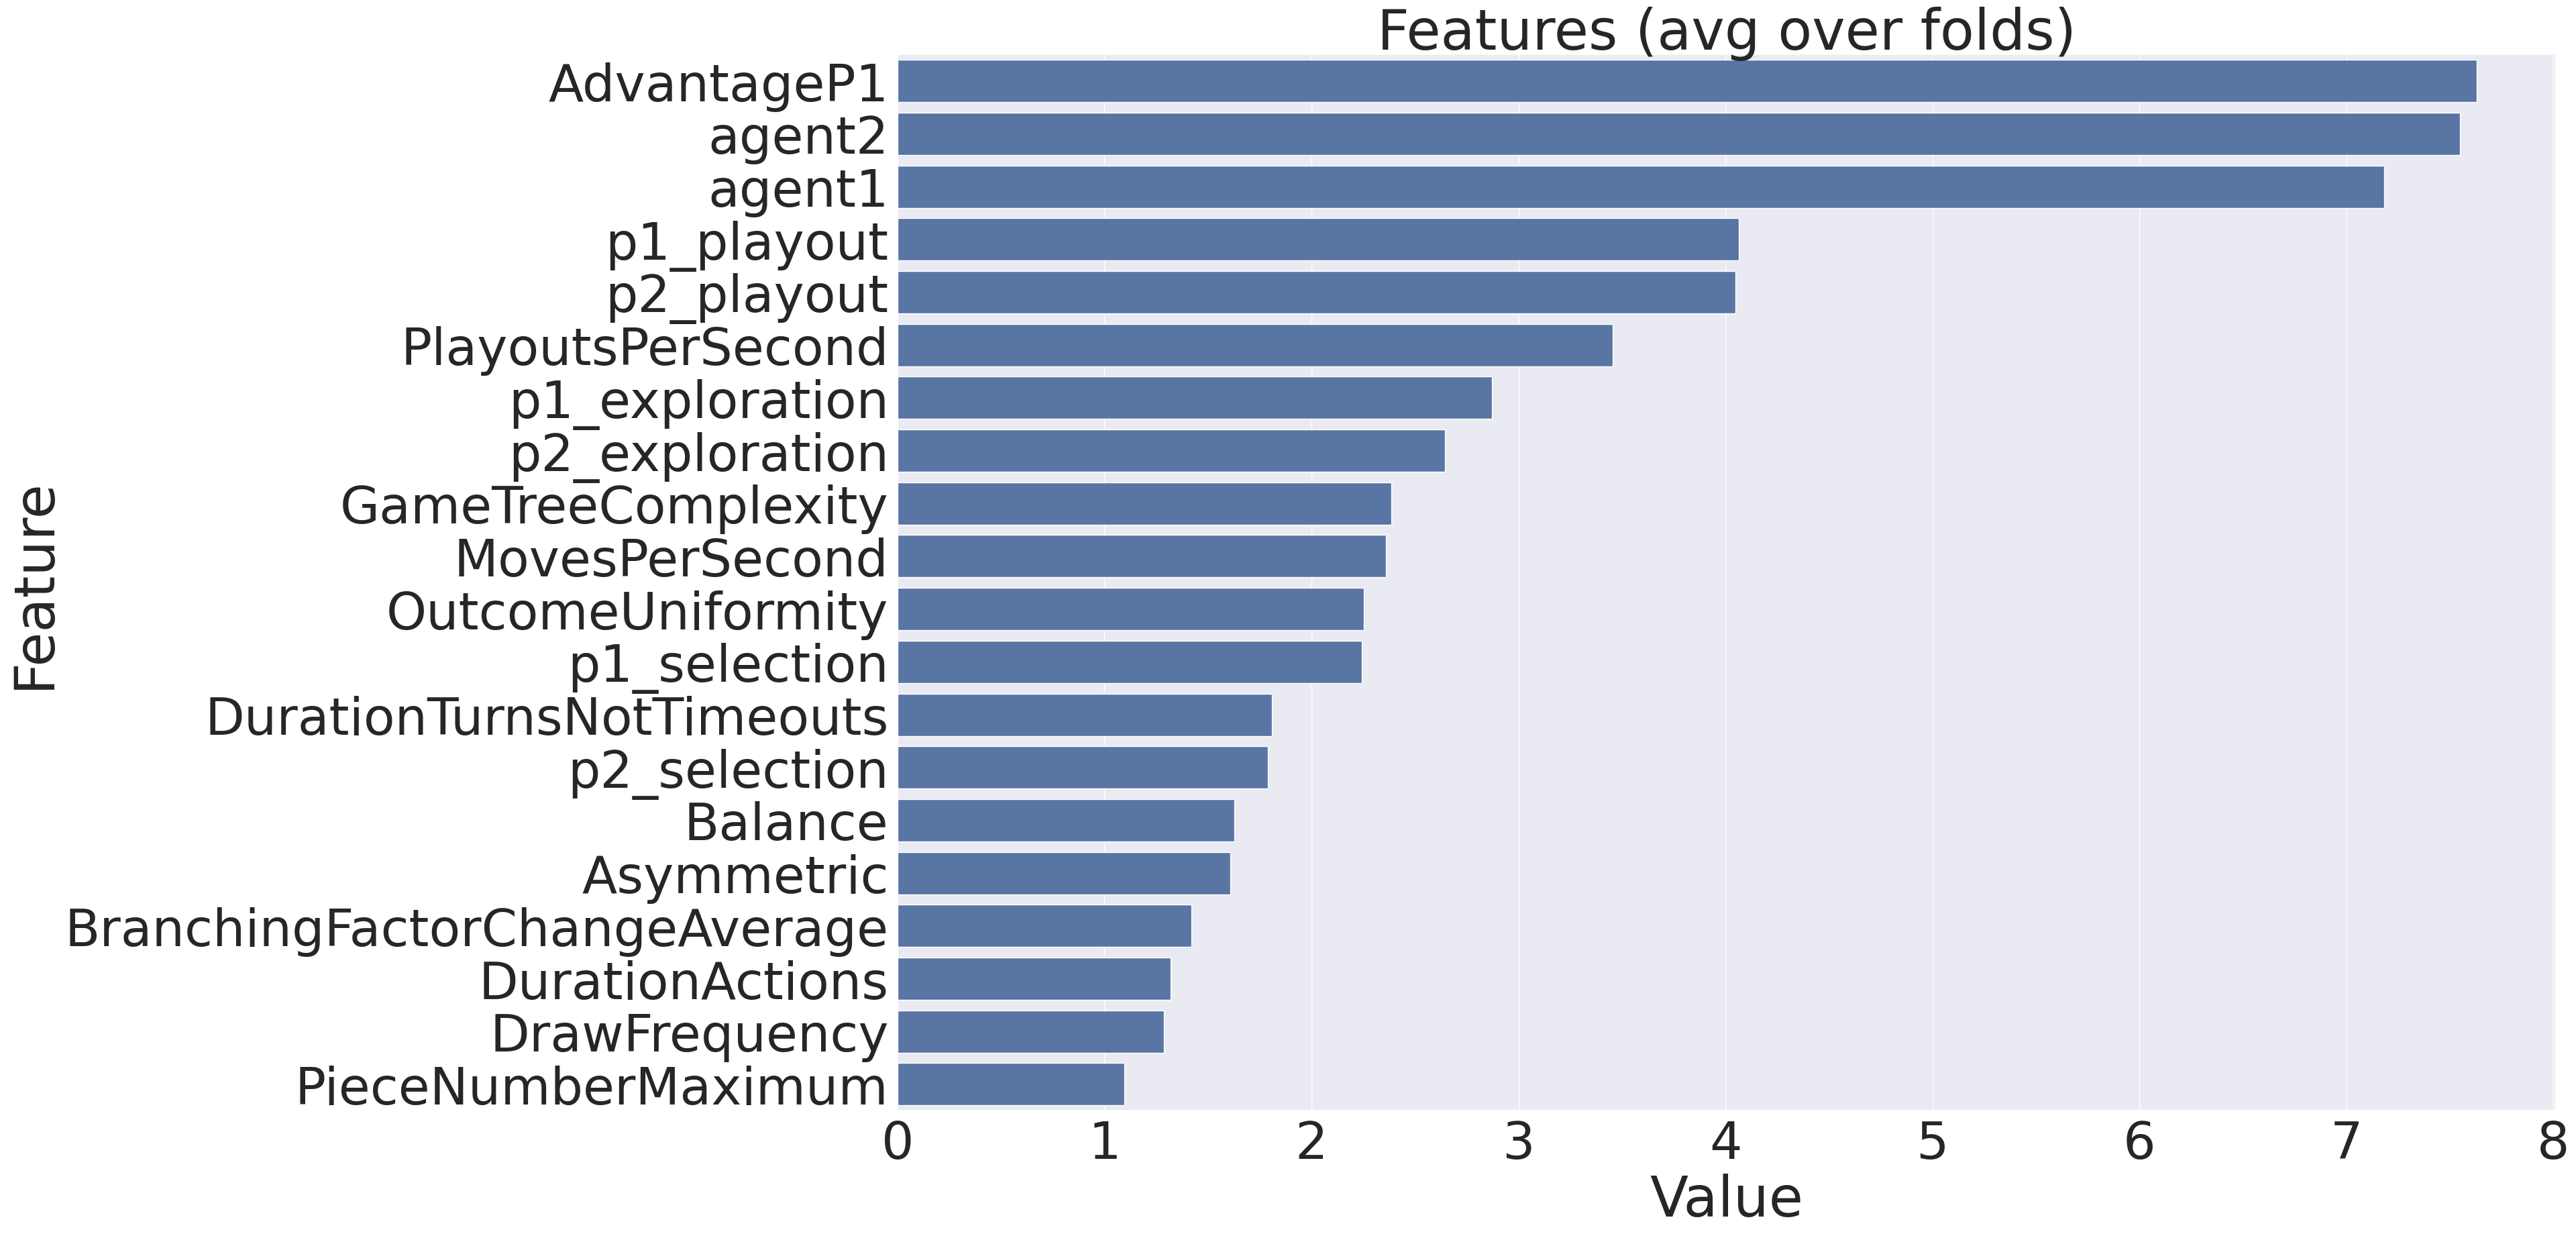

In [20]:
plotImp(cb,X)

# Full fit for inference

In [ ]:
## For full fit 
import pickle

X = train_df.drop(['utility_agent1','num_wins_agent1', 'num_draws_agent1', 'num_losses_agent1'], axis=1)
y = train_df['utility_agent1'].values

cb.fit(X, y - X["AdvantageP1"])

model_path = f'UM_ckpts/cb_fold_0.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(cb, file)

In [75]:
## For full fit 
import pickle

X = train_df.drop(['utility_agent1','num_wins_agent1', 'num_draws_agent1', 'num_losses_agent1'], axis=1)
y = train_df['utility_agent1'].values

lgbm.fit(X, y - X["AdvantageP1"])

model_path = f'UM_ckpts/cb_fold_0.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(lgbm, file)

In [12]:
!kaggle datasets version -p UM_ckpts/ -m "best cb + dart full fit"  --dir-mode zip

Starting upload for file cb_fold_0_multirmse.pkl
100%|████████████████████████████████████████| 237M/237M [00:10<00:00, 24.4MB/s]
Upload successful: cb_fold_0_multirmse.pkl (237MB)
Starting upload for file .ipynb_checkpoints.zip
100%|████████████████████████████████████████████| 223/223 [00:00<00:00, 296B/s]
Upload successful: .ipynb_checkpoints.zip (223B)
Dataset version is being created. Please check progress at https://www.kaggle.com/mohammad2012191/um-ckpts-2
Starting upload for file lgbm_fold_0.pkl
100%|██████████████████████████████████████| 72.1M/72.1M [00:04<00:00, 16.9MB/s]
Upload successful: lgbm_fold_0.pkl (72MB)
Starting upload for file cb_fold_0_multirmse.pkl
100%|████████████████████████████████████████| 237M/237M [00:09<00:00, 24.8MB/s]
Upload successful: cb_fold_0_multirmse.pkl (237MB)
Starting upload for file .ipynb_checkpoints.zip
100%|████████████████████████████████████████████| 218/218 [00:00<00:00, 305B/s]
Upload successful: .ipynb_checkpoints.zip (218B)
Dataset v